pip install tensorflow  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import imageio
import math
import IPython.display
import PIL
import os

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
patch_size = 64
mini_batch_size = 1
percent_used_for_validation = 0.1
output_kernel_size = 19
mode = "kpcn"
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [3]:
def imshow(data):
    data = np.clip(data, 0.0, 255.0).astype(np.uint8)
    pil_img = PIL.Image.fromarray(data, 'RGB')
    display(pil_img)
    return pil_img

In [4]:
class KernelAddingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(KernelAddingLayer, self).__init__()

#     def build(self, input_shape):
#         self.kernel = self.add_weight("kernel",
#                                       shape=[int(input_shape[-1]),
#                                              self.num_outputs])

#     def call(self, input):
#         l = input.shape[1] + 2
#         halfsize = output_kernel_size//2
#         output = None
#         expd_kernels = tf.math.exp(input[:,:,:,3:])
#         sums = tf.reduce_sum(expd_kernels, axis=3)
#         padded = tf.pad(divided, tf.constant([[0, 0], [halfsize, halfsize], [halfsize, halfsize]]), "CONSTANT")
#         padded = tf.stack([padded, padded, padded], axis=3)
        
#         for i in range(output_kernel_size):
#             for j in range(output_kernel_size):
#                 expd = tf.math.exp(input[:,:,:,3 + i*3 + j])
#                 divided = expd  / sums
#                 paddedInput = tf.pad(input[:,:,:,0:3], tf.constant([[0, 0], [i, output_kernel_size - i - 1], [j, output_kernel_size - j - 1], [0, 0]]), "CONSTANT")
#                 output = paddedInput * padded if output == None else output + paddedInput * padded
#         return output[:,halfsize:-halfsize,halfsize:-halfsize]

    def call(self, input):
        halfsize = output_kernel_size//2
        expd_kernels = tf.math.exp(input[:,:,:,3:])
        sums = tf.reduce_sum(expd_kernels, axis=3)
        reshaped_sums = tf.reshape(sums, (-1, sums.shape[1], sums.shape[2], 1))
        weights = expd_kernels / reshaped_sums
        padded_weights = tf.pad(weights, tf.constant([[0, 0], [halfsize, halfsize], [halfsize, halfsize], [0, 0]]), "CONSTANT")
        padded_weights = tf.stack([padded_weights, padded_weights, padded_weights], axis=3)
        output = tf.pad(input[:,:,:,:3]*0, [[0, 0], [output_kernel_size - 1, 0], [output_kernel_size - 1, 0], [0, 0]], "CONSTANT")
        
        for i in range(output_kernel_size):
            for j in range(output_kernel_size):
                padded_weight = padded_weights[:,:,:,:,i*3 + j]
                padded_input = tf.pad(input[:,:,:,0:3], tf.constant([[0, 0], [i, output_kernel_size - i - 1], [j, output_kernel_size - j - 1], [0, 0]]), "CONSTANT")
                output = output + padded_input * padded_weight

        return output[:,halfsize:-halfsize,halfsize:-halfsize]

# if mode == "kpcn":
#     pass
# layer = KernelAddingLayer()
# x = tf.ones([5, 1, 1, 3 + 19**2])
# output = layer(x)
# output[0,0,0]

In [5]:
class ChannelCroppingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ChannelCroppingLayer, self).__init__()

    def call(self, input):
        return input[:,:,:,:3]


In [6]:
def make_3_channels(image):
    if image.ndim == 2: image = np.dstack((image, image, image))
    image = image[:,:,:3]
    return image

def preprocess_color(color, albedo, epsilon=0.00316):
    return color.astype(np.float32) / (albedo + epsilon)

def postprocess_color(color, albedo, epsilon=0.00316):
    return color * (albedo + epsilon)

def preprocess_color_variance(variance, albedo, epsilon=0.00316):
    return variance / (albedo + epsilon)**2

def calculate_gradient(image):
    y, x, c = image.shape
    dx = image[:, 1:, :] - image[:, :x-1, :]
    dy = image[1:, :, :] - image[:y-1, :, :]
    dx = np.append(dx, np.zeros([y, 1, c]), axis=1)
    dy = np.append(dy, np.zeros([1, x, c]), axis=0)
    grad = np.dstack((dx, dy))
    return grad

def load_highspp(folder_path):
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    color = make_3_channels(imageio.imread(folder_path + "/color.png").astype(np.float32))
    # color = preprocess_color(color, albedo)
    return color

def load_lowspp(folder_path):
    print("loading " + folder_path)

    # albedo buffers
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    # albedo_variance = make_3_channels(imageio.imread(folder_path + "/albedoVariance.png").astype(np.float32))
    # albedo_gradient = calculate_gradient(albedo)

    # color buffers
    color = make_3_channels(imageio.imread(folder_path + "/color.png").astype(np.float32))
    # color = preprocess_color(color, albedo)
    color_variance = make_3_channels(imageio.imread(folder_path + "/colorVariance.png").astype(np.float32))
    # color_variance = preprocess_color_variance(color_variance, albedo)
    color_gradient = calculate_gradient(color)

    # depth buffers
    depth = imageio.imread(folder_path + "/depth.png").astype(np.float32)
    depth = depth.reshape((depth.shape[0], depth.shape[1], 1))
    # depth_variance = imageio.imread(folder_path + "/depthVariance.png").astype(np.float32)
    # depth_gradient = calculate_gradient(depth)

    # normal buffers
    normal = make_3_channels(imageio.imread(folder_path + "/normal.png").astype(np.float32))
    # normal_variance = make_3_channels(imageio.imread(folder_path + "/normalVariance.png").astype(np.float32))
    # normal_gradient = calculate_gradient(normal)

    # combined = np.dstack((albedo, albedo_gradient, color, color_variance, color_gradient, depth, depth_variance, depth_gradient, normal, normal_variance, normal_gradient))
    combined = np.dstack((color, color_variance, color_gradient, albedo, depth, normal))
    return combined

In [7]:
# split full res image into patch_size * patch_size images
def get_patches(image):
    x_patches = math.floor(image.shape[0]/patch_size)
    y_patches = math.floor(image.shape[1]/patch_size)
    patches = []
    for x in range(x_patches):
        for y in range(y_patches):
            xstart = x * patch_size
            xend = xstart + patch_size
            ystart = y * patch_size
            yend = ystart + patch_size
            temp = image[xstart:xend, ystart:yend, :]
            patches.append(temp)
        patches.append(image[xstart:xend, image.shape[1]-patch_size:, :])
    return patches

In [8]:
def is_mostly_black(patch):
    return np.mean(patch[:,:,:3].flatten(), axis=0) < 10.0

# note to self: use this https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets
def load_x_y_patches():
    x_patches = []
    y_patches = []
    orig = next(os.walk('./pngs'))[1]
    folders = [x[0:x.rindex('16')] for x in orig if '16' in x]

    for x in folders:
        low_spp = load_lowspp('./pngs/' + x + '16')
        high_spp = load_highspp('./pngs/' + x + '4096')
        # residual = high_spp - low_spp[:, :, 12:15]
        temp_x_patches = get_patches(low_spp)
        temp_y_patches = get_patches(high_spp)

        for i in range(len(temp_x_patches)):
            if not is_mostly_black(temp_y_patches[0]):
                x_patches.append(temp_x_patches[i])
                residual = temp_y_patches[i] - temp_x_patches[i][:,:,:3]
                # y_patches.append(residual)
                y_patches.append(temp_y_patches[i])
    
    return x_patches, y_patches


In [9]:
x_patches, y_patches = load_x_y_patches()

loading ./pngs/bathroom16
loading ./pngs/bathroom2-16
loading ./pngs/bedroom-16
loading ./pngs/car-16
loading ./pngs/car2-16
loading ./pngs/classroom-16
loading ./pngs/coffee-16
loading ./pngs/cornell-box-16
loading ./pngs/curly-hair-16
loading ./pngs/dining-room-16
loading ./pngs/dragon-16
loading ./pngs/furball-16
loading ./pngs/house-16
loading ./pngs/kitchen-16
loading ./pngs/lamp-16
loading ./pngs/living-room-16
loading ./pngs/living-room-2-16
loading ./pngs/living-room-3-16
loading ./pngs/material-testball-16
loading ./pngs/spaceship-16
loading ./pngs/staircase-16
loading ./pngs/staircase2-16
loading ./pngs/teapot-16
loading ./pngs/teapot-full-16
loading ./pngs/veach-ajar-16
loading ./pngs/veach-mis-16


In [10]:
x_patches[0].shape
# for i in range(1400, 1405):
#     residual = y_patches[i][:,:,:3]
#     x_patch = x_patches[i][:,:,:3]
#     total = x_patch + residual

#     imshow(total.astype(np.uint8))

(64, 64, 19)

In [11]:
def make_nn(input_channels):
    #basic model parameters
    L = 9
    kernel_size = 5
    hidden_channels = 100
    in_between_layers = L - 2

    # add layers
    noisy_input = keras.Input(shape=(patch_size, patch_size, input_channels))
    cropped_noisy_input = ChannelCroppingLayer()(noisy_input)
    x = noisy_input
    for i in range(in_between_layers):
        x = layers.ZeroPadding2D(padding=(2, 2))(x)
        x = layers.Conv2D(hidden_channels, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu")(x)

    x = layers.ZeroPadding2D(padding=(2, 2))(x)
    outputs = output_kernel_size**2 if mode == "kpcn" else 3
    x = layers.Conv2D(outputs, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="softmax")(x)
    x = layers.concatenate([cropped_noisy_input, x])
    
    x = KernelAddingLayer()(x)
    # compile model
    model = keras.Model(inputs=[noisy_input], outputs=[x])
    opt = keras.optimizers.Adam(learning_rate=10e-5)
    model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error'])

    return model

model = make_nn(x_patches[0].shape[2])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 19)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 68, 68, 19)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 100)  47600       zero_padding2d[0][0]             
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 68, 68, 100)  0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
def create_tf_dataset(x_patches, y_patches):
    validate_amount = math.floor(len(x_patches) * percent_used_for_validation)
    rec_count = len(x_patches)
    ds = tf.data.Dataset.from_tensor_slices((x_patches, y_patches))
    ds = ds.shuffle(buffer_size=400, reshuffle_each_iteration=True)
    train = ds.skip(validate_amount).batch(mini_batch_size)
    validate = ds.take(validate_amount).batch(mini_batch_size)
    return train, validate

In [13]:
# train, validate = prepare_training_data()
train, validate = create_tf_dataset(x_patches, y_patches)

In [14]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)
# model

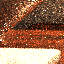

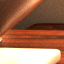

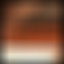

In [15]:
class DisplayImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DisplayImageCallback, self).__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 != 0:
            return

        # if predicting final output
        pn = 405
        xpatch = x_patches[pn]
        xpatchcolor = xpatch[:,:,:3]
        predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
        gt = y_patches[pn]

        imshow(xpatchcolor).save(checkpoint_dir + '/xpatch.png')
        imshow(gt).save(checkpoint_dir + '/gt.png')
        imshow(predicted).save(checkpoint_dir + '/prediction.png')

pn = 405
xpatch = x_patches[pn]
xpatchcolor = xpatch[:,:,:3]
predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
gt = y_patches[pn]

imshow(xpatchcolor).save(checkpoint_dir + '/xpatch.png')
imshow(gt).save(checkpoint_dir + '/gt.png')
imshow(predicted).save(checkpoint_dir + '/prediction.png')


In [ ]:
print("Fit model on training data")
image_cb = DisplayImageCallback()
history_cb = tf.keras.callbacks.CSVLogger('./training_2/log.csv', separator=",", append=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    train,
    validation_data=validate,
    epochs=10000,
    callbacks=[cp_callback, history_cb, image_cb]
)

Fit model on training data
Epoch 1/10000


In [ ]:
# print(model.layers[1].get_weights()[0])
# model.predict(xpatch)

In [ ]:
newpatch = x_patches[1350] #np.reshape(x_patches[1350], (1, 64, 64, 40))
newpatch = np.stack((newpatch, newpatch, newpatch, newpatch, newpatch), axis=0)
newpatch.shape

In [ ]:
pn = 405
xpatch = x_patches[pn]
xpatch = np.stack((xpatch, xpatch, xpatch, xpatch, xpatch), axis=0)
prediction = model.predict(xpatch)
prediction
xpatch

In [ ]:
# imshow((prediction[0] * 255.0).astype(np.uint8))
prediction